# Pytorch Resnets
This project is motivated by my desire to deeply understand the state of art architecutre 'Residual network' AKA 'Resnet'. When I was studying CNNs for visual recognition I always tried to understand papers first then re-implement by myself using favourite tools e.g Pytorch or Numpy. However, I could not fint any tutorial to re-implement Resnet based architures from scratch using pytorch (All I could find using PyTorch Implemented models from Model Zoo) So I decided to try myself mainly by looking on CS231n lecture notes (Mainly raw NumPy based code) and re-implent it using only PyTorch


So far (In previous notebooks), I used PyTorch only to accelarate computation using GPU.

But this time I will let myself to utilize PyTorch's useful packages, which help to design deep neural networks efficiently.

The `torch.autograd` package provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions.

In previous notebooks, I performed backprop manually (To practice and develope better intuition)
Now, to obtain gradients for a tensor via autograd from arbitrary scalar valued functions, I simply set `requires_grad=True`.

The `torch.nn` package defines a set of Modules, which I will start to use.



## Installing module
I will continue using some functions that was developed by research group of University of Michigan to help utilize PyTorch on low-level functionality: [`coutils` package](https://github.com/deepvision-class/starter-code).


In [ ]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-3xbnkyfd
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-3xbnkyfd
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10324 sha256=4c399641d3d8970dd2d3abe918e7e31d1dc56354751527cc5bb42cc2059f7497
  Stored in directory: /tmp/pip-ephem-wheel-cache-g5rgrb6t/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


## Setup code
Some setup code for this notebook.

In [ ]:
import coutils
from coutils import fix_random_seed

from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here I set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; I've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# I set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so I wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. I divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Extracting ./datasets/cifar-10-python.tar.gz to ./datasets
Files already downloaded and verified
Files already downloaded and verified


if CUDA is not enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment.

I will be using `torch.float = torch.float32` for data and `torch.long = torch.int64` for labels.

Please refer to https://pytorch.org/docs/stable/tensor_attributes.html#torch-dtype for more details about data types.

In [ ]:
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

# Constant to control how frequently I print train loss
print_every = 100

print('using device:', device)

using device: cuda:0


I am going to implement and show [ResNet](https://arxiv.org/abs/1512.03385), one of the state-of-the-art CNN architecture.
Specifically, I am going to implement a variation of ResNet called [PreResNet](https://arxiv.org/abs/1603.05027), which locates activation before each convolutional layer (so called pre-activation).
I will first implement a plain building block, residual block, and then bottleneck block for really deep networks.
Finally, I will implement ResNet using those blocks.

Throughout this part, I will follow the PyTorch default weight initialization for conciseness.

## Plain block

First, I need to implement a plain block without residual connection.
PreResNet has a different order of layers from the previously implemented ones;
BatchNorm and ReLU precedes Conv.
The name of PreResNet comes form this pre-activation architecture.
Here, for downsampling, I don't introduce MaxPool layers explicitly, but use stride 2 in the first Conv layer in the block.

Concretely, a plain block accepts a feature map of shape $C_{in} \times H_{in} \times W_{out}$ and produces a feature map of shape $C_{out} \times H_{out} \times W_{out}$. If the block performs downsampling, then $W_{out}=W_{in}/2$ and $H_{out}=H_{in}/2$; otherwise $H_{out}=H_{in}$ and $W_{out}=W_{in}$. The plain block consists of the following six layers in order:

1. Spatial Batch normalization
2. ReLU
3. Convolutional layer with `Cout` 3x3 filters, zero-padding of 1, and stride 2 if downsampling; otherwise stride 1
4. Spatial Batch normalization
5. ReLU
6. Convolutional layer with `Cout` 3x3 filters, with zero-padding of 1


In [ ]:
class PlainBlock(nn.Module):
  def __init__(self, Cin, Cout, downsample=False):
    super().__init__()

    if downsample:
        stride = 2
    else:
        stride = 1
    self.net = nn.Sequential(nn.BatchNorm2d(Cin),
                             nn.ReLU(),
                             nn.Conv2d(Cin,Cout,3,stride=stride,padding=1),
                             nn.BatchNorm2d(Cout),
                             nn.ReLU(),
                             nn.Conv2d(Cout,Cout,3,padding=1))

  def forward(self, x):
    return self.net(x)

In [ ]:
data = torch.zeros(2, 3, 5, 6)
model = PlainBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of PlainBlock without downsampling has a *correct* dimension!')
else:
  print('The output of PlainBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
model = PlainBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of PlainBlock with downsampling has a *correct* dimension!')
else:
  print('The output of PlainBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of PlainBlock without downsampling has a *correct* dimension!
The output of PlainBlock with downsampling has a *correct* dimension!


## Residual block

Now I will implement a residual block.
A residual block adds a residual connection to a plain block. Let $\mathcal{F}$ be a plain block; then the residual version  $\mathcal{R}$ of the plain block $\mathcal{F}$ computes:

$\mathcal{R}(x) = \mathcal{F}(x) + x$

However, this implementation will only work if the output from the plain block $\mathcal{F}(x)$ has the same shape as the input $x$. Based on the plain block that I implemented above, there are two cases where the output of the plain block can have a different shape than the input:

1. The number of output channels $C_{out}$ is different from the number of input channels $C_{in}$
2. The plain block $\mathcal{F}$ performs spatial downsampling

To deal with these cases, it is needed to generalize definition of the residual block and add a *shortcut connection* $\mathcal{G}$:

$\mathcal{R}(x) = \mathcal{F}(x) + \mathcal{G}(x)$

There are three cases for the shortcut connection $\mathcal{G}$:

1. If $C_{in}=C_{out}$ and $\mathcal{F}$ does not perform downsampling, then $\mathcal{F}(x)$ will have the same shape as $x$, so $\mathcal{G}$ is the identity function: $\mathcal{G}(x) = x$
2. If $C_{in} \neq C_{out}$ and $\mathcal{F}$ does not downsample, then $\mathcal{G}$ is a 1x1 convolution with $C_out$ filters and stride 1.
3. If $\mathcal{F}$ downsamples, then $\mathcal{G}$ is a 1x1 convolution with $C_{out}$ filters and stride 2.


In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, Cin, Cout, downsample=False):
    super().__init__()
                               
    # Cin: number of input channels                                          
    # Cout: number of output channels                                        
    # downsample: add downsampling (a conv with stride=2) if True            
    self.block = PlainBlock(Cin,Cout,downsample)
    if downsample:
        stride = 2
    else:
        stride = 1
    self.shortcut = nn.Identity()
    if Cin != Cout or downsample:
        self.shortcut = nn.Sequential(nn.Conv2d(Cin,Cout,1,stride=stride,padding=0))
  
  def forward(self, x):
    return self.block(x) + self.shortcut(x)

In [ ]:
data = torch.zeros(2, 3, 5, 6)
model = ResidualBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
model = ResidualBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of ResidualBlock with downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!
The output of ResidualBlock with downsampling has a *correct* dimension!


## Residual stage


In [ ]:
class ResNetStage(nn.Module):
  def __init__(self, Cin, Cout, num_blocks, downsample=True,
               block=ResidualBlock):
    super().__init__()
    blocks = [block(Cin, Cout, downsample)]
    for _ in range(num_blocks - 1):
      blocks.append(block(Cout, Cout))
    self.net = nn.Sequential(*blocks)
  
  def forward(self, x):
    return self.net(x)

In [ ]:
print('Plain block stage:')
print(ResNetStage(3, 4, 2, block=PlainBlock))
print('Residual block stage:')
print(ResNetStage(3, 4, 2, block=ResidualBlock))

Plain block stage:
ResNetStage(
  (net): Sequential(
    (0): PlainBlock(
      (net): Sequential(
        (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): PlainBlock(
      (net): Sequential(
        (0): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
)
Residual block stage:
ResNetStage(
  (net): Sequential(
    (0): 

## Residual stem

A "stem" layer is required at the beginning of the network, which increases the number of channels while keeping the other dimensions.


In [ ]:
class ResNetStem(nn.Module):
  def __init__(self, Cin=3, Cout=8):
    super().__init__()
    layers = [
        nn.Conv2d(Cin, Cout, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
    ]
    self.net = nn.Sequential(*layers)
    
  def forward(self, x):
    return self.net(x)

In [ ]:
data = torch.zeros(2, 3, 5, 6)
model = ResNetStem(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!


## ResNet class

Now, I need to design the ResNet class using the blocks implemented above

For general applicability, the class will get a dictionary of the architecture specification as an input, and parse it to build a CNN.

To avoid dependency on the size of the input, ResNet has an average pooling at the end of the convolutional part, such that the size of the input tensor to the linear layer is always `(batch_size, stage_args[-1][1])`.
It is possible to add an average pooling layer (`nn.AvgPool2d`), but it requires to know the size of the input.
Solution is performing average pooling in `forward`.

In [ ]:
# example of specifications
networks = {
  'plain32': {
    'block': PlainBlock,
    'stage_args': [
      (8, 8, 5, False),
      (8, 16, 5, True),
      (16, 32, 5, True),
    ]
  },
  'resnet32': {
    'block': ResidualBlock,
    'stage_args': [
      (8, 8, 5, False),
      (8, 16, 5, True),
      (16, 32, 5, True),
    ]
  },
}

In [ ]:
class ResNet(nn.Module):
  def __init__(self, stage_args, Cin=3, block=ResidualBlock, num_classes=10):
    super().__init__()

    # Implementation of the convolutional part of ResNet using ResNetStem,       
    # ResNetStage, and wraping the modules by nn.Sequential.                
    blocklist = [ResNetStem(Cin=Cin,Cout=stage_args[0][0])]
    for i in range(len(stage_args)):
        blocklist.append(ResNetStage(*stage_args[i],block=block))
    self.cnn = nn.Sequential(*blocklist)
    self.fc = nn.Linear(stage_args[-1][1], num_classes)
  
  def forward(self, x):

    scores = self.cnn(x)
    scores = F.avg_pool2d(scores,scores.shape[2])
    scores = torch.reshape(scores,(scores.shape[0],-1))
    scores = self.fc(scores)

    return scores

def get_resnet(name):
  return ResNet(**networks[name])

## Training

Now I will train a few epochs of plain and residual networks with 32 layers on CIFAR.
Expected result is that deep non-residual networks don't converge well.

**Disclaimer: The performance of PreResNet-32 here (~ 80%) would be lower than the best performance this model can achieve, because the convergence requires much more training.**

In [ ]:
# def init_module(model):
#   for m in model.modules():
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#       nn.init.kaiming_normal_(m.weight.data)
#       if m.bias is not None: nn.init.zeros_(m.bias.data)
#     elif isinstance(m, nn.BatchNorm2d):
#       nn.init.ones_(m.weight.data)
#       if m.bias is not None: nn.init.zeros_(m.bias.data)

names = ['plain32', 'resnet32']
acc_history_dict = {}
iter_history_dict = {}
for name in names:
  fix_random_seed(0)
  print(name, '\n')
  model = get_resnet(name)
#   init_module(model)
  
  optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=.9, weight_decay=1e-4)

  acc_history, iter_history = train_part345(model, optimizer, epochs=10, schedule=[6, 8], verbose=False)
  acc_history_dict[name] = acc_history
  iter_history_dict[name] = iter_history

plain32 

Epoch 0, Iteration 765, loss = 1.5688
Checking accuracy on validation set
Got 364 / 1000 correct (36.40)

Epoch 1, Iteration 1531, loss = 1.4389
Checking accuracy on validation set
Got 443 / 1000 correct (44.30)

Epoch 2, Iteration 2297, loss = 1.3646
Checking accuracy on validation set
Got 506 / 1000 correct (50.60)

Epoch 3, Iteration 3063, loss = 1.2265
Checking accuracy on validation set
Got 557 / 1000 correct (55.70)

Epoch 4, Iteration 3829, loss = 1.1677
Checking accuracy on validation set
Got 569 / 1000 correct (56.90)

Epoch 5, Iteration 4595, loss = 1.1741
Checking accuracy on validation set
Got 610 / 1000 correct (61.00)

lr decay from 0.01 to 0.001
Epoch 6, Iteration 5361, loss = 0.8380
Checking accuracy on validation set
Got 690 / 1000 correct (69.00)

Epoch 7, Iteration 6127, loss = 0.8750
Checking accuracy on validation set
Got 701 / 1000 correct (70.10)

lr decay from 0.001 to 0.0001
Epoch 8, Iteration 6893, loss = 1.0098
Checking accuracy on validation set
Go

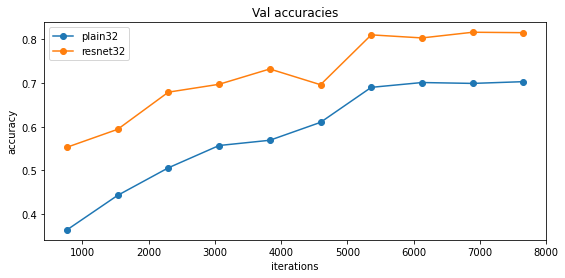

In [ ]:
plt.title('Val accuracies')
for name in names:
  plt.plot(iter_history_dict[name], acc_history_dict[name], '-o')
plt.legend(names, loc='upper left')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()

## Residual bottleneck block

A bottleneck block is often useful for better efficiency, especially when importing a model to mobile devices.
The residual bottleneck block is similar to the standard residual block, but the plain block part has a different architecture:
it consists of 3 convolutional layers, and the first two convolutional layers have a smaller number of channels.

Here is the specification of the bottleneck block:

1. Spatial Batch normalization
2. ReLU
3. Convolutional layer with `Cout // 4` 1x1 filters, stride 2 if downsampling; otherwise stride 1
4. Spatial Batch normalization
5. ReLU
6. Convolutional layer with `Cout // 4` 3x3 filters, with zero-padding of 1
7. Spatial Batch normalization
8. ReLU
9. Convolutional layer with `Cout` 1x1 filters


In [ ]:
class ResidualBottleneckBlock(nn.Module):
  def __init__(self, Cin, Cout, downsample=False):
    super().__init__()

    # Implementation of residual bottleneck block.                               
    # Inputs:                                                                  
    # Cin: number of input channels                                          
    # Cout: number of output channels                                        
    # downsample: add downsampling (a conv with stride=2) if True            
    if downsample:
        stride = 2
    else:
        stride = 1
    self.block = nn.Sequential(nn.BatchNorm2d(Cin),
                               nn.ReLU(),
                               nn.Conv2d(Cin,Cout//4,1,stride=stride,padding=0),
                               nn.BatchNorm2d(Cout//4),
                               nn.ReLU(),
                               nn.Conv2d(Cout//4,Cout//4,3,padding=1),
                               nn.BatchNorm2d(Cout//4),
                               nn.ReLU(),
                               nn.Conv2d(Cout//4,Cout,1,padding=0))
    self.shortcut = nn.Identity()
    if Cin != Cout or downsample:
        self.shortcut = nn.Sequential(nn.Conv2d(Cin,Cout,1,stride=stride,padding=0))

  def forward(self, x):
    return self.block(x) + self.shortcut(x)

In [ ]:
data = torch.zeros(2, 3, 5, 6)
model = ResidualBottleneckBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
model = ResidualBottleneckBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of ResidualBlock with downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!
The output of ResidualBlock with downsampling has a *correct* dimension!


In [ ]:
# example of specification
networks.update({
  'resnet47': {
    'block': ResidualBottleneckBlock,
    'stage_args': [
      (32, 32, 5, False),
      (32, 64, 5, True),
      (64, 128, 5, True),
    ],
  },
})

print(get_resnet('resnet47'))

ResNet(
  (cnn): Sequential(
    (0): ResNetStem(
      (net): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
    )
    (1): ResNetStage(
      (net): Sequential(
        (0): ResidualBottleneckBlock(
          (block): Sequential(
            (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
            (2): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (4): ReLU()
            (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (7): ReLU()
            (8): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (shortcut): Identity()
        )
        (1): ResidualBottleneckBlock(
          (block): Sequential(